In [4]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# For importing qubalab during development
lib_path = '/qubalab'

import sys
if not lib_path in sys.path:
    sys.path.append(lib_path)

import qubalab

import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## View image with OpenSlide/TiffSlide

Here, we use the OpenSlideServer to read an image from a file.
This is entirely separate from any QuPath-related stuff.

As a bonus, we try to show the same image after wrapping it in an IccProfileServer, which tries to apply an ICC Profile to the image.
This should work for most .svs images, which embed an ICC Profile, but probably won't for other images.

For some info on why this may be useful, see http://www.andrewjanowczyk.com/application-of-icc-profiles-to-digital-pathology-images/

/Users/lleplat/QuPath/Projects/qubalab/qubalab/qubalab/images/servers.py:529: UserWarning: No ICC Profile found for /Users/lleplat/QuPath/Images/CMU-1.tiff
  warnings.warn(f'No ICC Profile found for {base_server.path}')


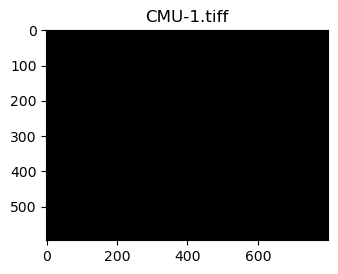

In [7]:
path = '/Users/lleplat/QuPath/Images/CMU-1.tiff'

from qubalab.qubalab.images.openslide import OpenSlideServer

server = OpenSlideServer(path)

# Request the lowest-resolution image from the pyramid
im = server.read_region(downsample=server.downsamples[-1])

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.title(server.name)

# Try to show image with ICC profile, if we have it
if server.is_rgb:
    server_icc = qubalab.qubalab.images.servers.IccProfileServer(server)
    if server_icc.icc_transform is not None:
        im_icc = server_icc.read_region(downsample=server.downsamples[-1])
        print(im_icc.mean())
        plt.subplot(1, 2, 2)
        plt.title(f'{server.name} (ICC)')
        plt.imshow(im_icc)

plt.show()

## Prepare to use Dask

A nicer way to access pixels is via Dask.

Not entirely sure if this is necessary, but we can turn on opportunistic caching to try to speed things up.

https://docs.dask.org/en/stable/caching.html#automatic-opportunistic-caching

In [8]:
from dask.cache import Cache
cache = Cache(2e9)  # Leverage two gigabytes of memory
cache.register()

## Request pixels as a dask array

We can also request pixels as a dask array.

As long as we don't call 'compute()' or try to show the whole image, this gives as a NumPy-like way to access the pixels - even when it's very large.

> **Important!**
> It turns out that requesting at an arbitrary downsample level is very slow - which is why we use a downsample corresponding to a stored resolution level here.
>
> See `ImageServer.to_dask()` for the reason why.
>
> We need something much faster than dask's `affine_transform` method.

In [9]:
im_small = server.to_dask(downsample=server.downsamples[-1])
display(im_small)

im_full = server.to_dask(downsample=server.downsamples[0])
display(im_full)

dask.array<reshape, shape=(1, 1, 1, 596, 800, 3), dtype=uint8, chunksize=(1, 1, 1, 596, 800, 3), chunktype=numpy.ndarray>

dask.array<reshape, shape=(1, 1, 1, 38144, 51200, 3), dtype=uint8, chunksize=(1, 1, 1, 1024, 1024, 3), chunktype=numpy.ndarray>

Find the 'darkest' region in a small image, and then crop that out from the large image.

ValueError: zero-size array to reduction operation minimum which has no identity

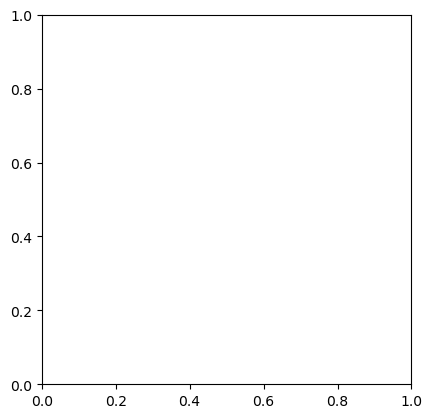

In [10]:
import numpy as np

im_small = im_small.squeeze()
im_full = im_full.squeeze()

darkest_index = im_small.mean(axis=-1).argmin()
row, col = np.unravel_index(darkest_index, im_small.shape[:2])
scale_row = im_full.shape[0] // im_small.shape[0]
scale_col = im_full.shape[1] // im_small.shape[1]

im_detail = im_full[...,
           int(row * scale_row - scale_row*4):int(row * scale_row + scale_row*4),
           int(col * scale_col - scale_col*4):int(col * scale_col + scale_col*4),
           :]
plt.imshow(im_detail)
plt.show()


## View the image with Napari

We can also view the image with Napari: https://napari.org/

In [14]:
from qubalab.qubalab.images import to_dask
import napari

# This uses some older code - we'd ideally use server.to_dask() instead,
# but here we get this in a more immediately Napari-friendly form
napari.view_image(**to_dask(server, as_napari_kwargs=True))
napari.run()


ImportError: lxml.html.clean module is now a separate project lxml_html_clean.
Install lxml[html_clean] or lxml_html_clean directly.

## Explore AICSImageIO

We can also read images using AICSImageIO.

For whole slide images, this typically requires Bio-Formats - and therefore Java - so we don't want it to be a strict requirement.
Also, performance isn't as good as with OpenSlide.

But we do want to reward those who go to the trouble of installing it, since it also gives access to lots more image formats, including multi-channel images.

AICSImageIO doesn't currently support image pyramids, so there is a bit of hacking going on to figure out which 'scenes' are really resolution levels.

But that's the reason to use `AICSImageIoServer` rather than `AICSImage` directly.

In [15]:
from qubalab.images.aicsimageio import AICSImageIoServer
server = AICSImageIoServer(path)


ModuleNotFoundError: No module named 'qubalab.images'

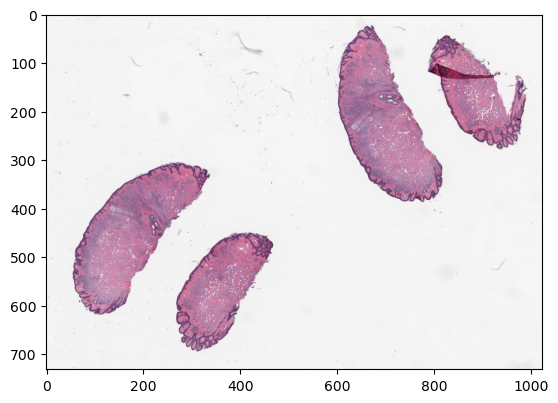

In [8]:
# Alternative syntax to request a dask array for a single resolution level
im_smallish = server.level_to_dask(level=server.n_resolutions-1)
plt.imshow(im_smallish.squeeze())

## Read image from QuPath

Finally, we explore accessing the current image from QuPath.

This assumes you're running QuPath with the Py4J extension, and press the 'Start Gateway' button in the toolbar.

In [9]:
from qubalab.qupath import QuPathServer

from py4j.java_gateway import JavaGateway, GatewayParameters

# Using auto_convert makes things easier by converting Python collections to Java collections
gateway = JavaGateway(gateway_parameters=GatewayParameters(auto_convert=True))
qp = gateway.entry_point

qupath_server = qp.getQuPath().getImageData().getServer()
server = QuPathServer(gateway=gateway, server_obj=qupath_server)

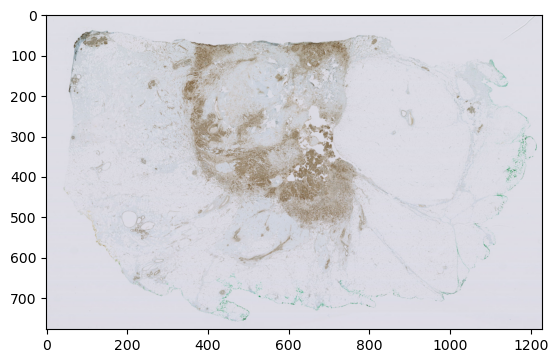

In [10]:
# We can read with a QuPath-like API, or the dask API
im = server.read_region(downsample=100)
if im.ndim == 3 and im.shape[-1] == 3:
    plt.imshow(im)
else:
    plt.imshow(im[:, :, 0])
plt.show()

In [11]:
# We can also optionally use Napari
# napari.view_image(**qubalab.images.to_dask(server, rgb=server.is_rgb, as_napari_kwargs=True))
# napari.run()

## Explore QuPath objects

Some initial code to access QuPath objects.

In [12]:
from qubalab.qupath.py4j import get_path_objects

path_objects = get_path_objects()

/Users/petebankhead/Documents/GitHub/petebankhead/qubalab/qubalab/qupath/py4j.py:230: UserWarning: Attempting to create new JavaGateway
  warnings.warn('Attempting to create new JavaGateway')


### Convert to shapely objects

Quick demo to show converting to shapely objects.

This could be improved...

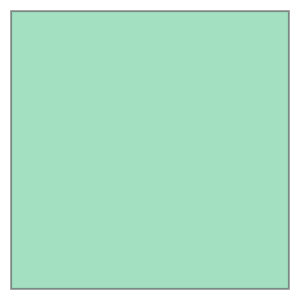

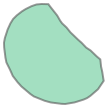

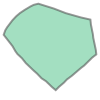

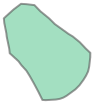

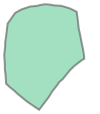

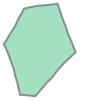

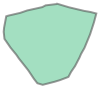

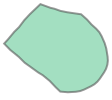

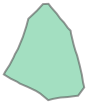

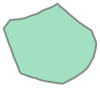

In [13]:
from shapely.geometry import shape

shapes = [shape(p.geometry) for p in path_objects if p.geometry is not None]
for s in shapes[:min(10, len(shapes))]:
    display(s)